# LSM CEF Equation Of State Fitting 

## Generating the CEF equations to fit for LSM

In [1]:
# General modules and settings


scan_alpha = False # Whether to do hyperparameter optimization for alpha (takes about 35 minutes extra)
res_dir='results_wexpt/' # Directory where results will be stored
overwrite_results =  True # Whether to overwrite existing data in results folder with new data

In [9]:
# Supporting functions
import os
def create_directory(dir_name):
    try:
        os.makedirs(dir_name, exist_ok=True)
        print(f"Directory '{dir_name}' created or already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [2]:
# Generate the CEF equations for LSM
from HydroGEN_CEF_general_current import *

# Set the lattice string for LSM
lattice='(La,Sr,Va)1(Mn,Va)1(O,Va)3'

# Generate the CEF equations for fitting Gibbs energy without configurational entropy
# These expressions are currently being saved to the file CEF_LaMnO
generate_cef_module(lattice,G_neutral_values=[],T_terms=[1,T,T*log(T)],ir=(-1,-1),use_neutral=False)

[1.0, 1.0, 3.0]
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this combination of conditions!
No "exact" solution for this com

## Read in and parse the CEF expressions

In [3]:
# Read in relevant modules and set some global parameters
import re
import os
import numpy as np
import math
from shutil import copyfile,rmtree
import copy
from sympy import symbols, solve, simplify, sympify, preorder_traversal, Float, log, diff, apart
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fmin_l_bfgs_b
r = 8.617333262E-5; # Boltzman constant in eV/K.
R=8.314 # gas constant in J / mol·K
emax=2.99 # highest O stoichiometry used for fitting.
color_table=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']+['xkcd:salmon','xkcd:light green','xkcd:yellow'
    ,'xkcd:navy','xkcd:light pink','xkcd:gold','xkcd:neon pink','xkcd:baby blue','xkcd:forrest green'
    ,'xkcd:cobalt blue','xkcd:reddish pink','xkcd:hot purple','xkcd:ecru','xkcd:rust red'
    ,'xkcd:fern green','xkcd:rose red']

y0_values=[0,0.1,0.2,0.3,0.4,0.5]

In [4]:
# Read Gibbs Energy expression in from CEF_LaMnO file
cef_results='CEF_LaMnO'
with open(cef_results,'r') as f:
	c=f.readlines()

for i in range(len(c)):
	if 'Nonconfigurational-Gibbs energy with T expansion:' in c[i]:
		str_G_ncf=c[i+1].strip('\n')
	if 'Total Gibbs energy with T expansion:' in c[i]:
		str_G=c[i+1].strip('\n')
	if 'Independent site fractions:' in c[i]:
		str_y=c[i+1].strip('\n')
	if 'Endmember parameters:' in c[i]:
		str_a=c[i+1].strip('\n')
	if 'Independent excess parameters:' in c[i]:
		str_L=c[i+1].strip('\n')

sy=str_y.strip('[').strip(']').split(', ')
y=[symbols('y'+str(i)) for i in range(len(sy))]
a=symbols(str_a.strip('[').strip(']').replace(',',' '))
L=symbols(str_L.strip('[').strip(']').replace(',',' '))
T=symbols('T')

dreplace={}
for i in range(len(sy)):
	dreplace[sy[i]]=str(y[i])

for key,value in dreplace.items():
	str_G_ncf=str_G_ncf.replace(key,value)
	str_G=str_G.replace(key,value)

G_ncf=sympify(str_G_ncf)
G=sympify(str_G)

# fix to reference perfect compound T-dependence
G=G.subs(symbols('a_0_1'),0).subs(symbols('a_0_2'),0)
G_ncf=G_ncf.subs(symbols('a_0_1'),0).subs(symbols('a_0_2'),0)

G_ncf_0K=G_ncf.subs(log(T),0).subs(T,0)
G_ncf_0K=simplify(G_ncf_0K.expand())

## Read in DFT and experimental data

In [5]:
# Read in data files

# read 0K DFT data
data=np.loadtxt('data')
data_0K=data[data[:,-2]==0]

# lasso feature selection
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes

L_features=[diff(G_ncf_0K,i) for i in L]
a_features=[diff(G_ncf_0K,i) for i in a]

X=[]
f=[]
for i in range(data_0K.shape[0]):
	y_values=data_0K[i,:][0:len(y)]
	d_y_subs={}
	for j in range(len(y)):
		d_y_subs[y[j]]=y_values[j]
	L_features_values=[j.subs(d_y_subs) for j in L_features]
	a_features_values=[j.subs(d_y_subs) for j in a_features]
	X.append(L_features_values+a_features_values)
	f.append(data_0K[i,:][-1])

# read O2 Gibbs energy
mu_ft=np.loadtxt('O2_janaf')
T_O2=mu_ft[:,0]
S_O2=mu_ft[:,2]
H_O2=mu_ft[:,4]
G_O2=H_O2*1000-T_O2*S_O2 # J/mol O2
G_O2=G_O2/(1.6e-19)/(6.02e23) # eV per O2
G_O2=G_O2-G_O2[0]
G_O=G_O2/2

from scipy import interpolate
G_O_ip=interpolate.interp1d(T_O2, G_O)

for n in range(len(y0_values)):
    if y0_values[n]!=0:
        Ga_op=G.subs({y[1]*log(y[1]):0,y[2]*log(y[2]):0}).subs({y[0]:y0_values[n],y[1]:0,y[2]:0})
    else:
        Ga_op=G.subs({y[0]*log(y[0]):0,y[1]*log(y[1]):0,y[2]*log(y[2]):0}).subs({y[0]:0,y[1]:0,y[2]:0})
    mu_O_op=-diff(Ga_op,y[-1])/3
    mu_O_op=simplify(mu_O_op.expand())
    L_features_op=[diff(mu_O_op,i) for i in L]
    a_features_op=[diff(mu_O_op,i) for i in a]
    d_zeros={}
    for i in L:
        d_zeros[i]=0
    for i in a:
        d_zeros[i]=0
    c_op=mu_O_op.subs(d_zeros) # terms without L and a
    import glob
    fexpt0=glob.glob('expt_*')
    fexpt=[]
    for j in range(len(fexpt0)):
        with open(fexpt0[j],'r') as files:
            if float(files.readlines()[0].strip('#'))==y0_values[n]:
                fexpt.append(fexpt0[j])
    expt=[np.loadtxt(i) for i in fexpt]
    for j in range(len(expt)):
        expt_current=expt[j][expt[j][:,1]<emax]
        for i in range(expt_current.shape[0]):
            d_subs={T:expt_current[i,2],y[-1]:(3-expt_current[i,1])/3}
            L_features_op_values=[k.subs(d_subs) for k in L_features_op]
            a_features_op_values=[k.subs(d_subs) for k in a_features_op]
            X.append(L_features_op_values+a_features_op_values)        
            mu=1/2*r*expt_current[i,2]*np.log(expt_current[i,0])+G_O_ip(expt_current[i,2])
            f.append(mu-c_op.subs(d_subs)) 

X=np.array(X)
f=np.array(f)
scaler = StandardScaler(with_mean=False)
scaler.fit(X)
X_st=scaler.transform(X)

features = [str(i) for i in L]+[str(i) for i in a]

## Determine fitting hyperparameters
Do a grid scan to determine a good value for alpha in the LASSO fitting approach

In [6]:
if scan_alpha: 

    # Runs to gather data for alpha-importance diagram
    clf = Lasso(alpha=1e-11,tol=1e-13,max_iter=int(1e7),fit_intercept=False)
    clf.fit(X_st, f)
    importance0 = np.abs(clf.coef_)

    n_alpha = 23
    # log_alpha=[-11+0.2*i for i in range(56)]
    log_alpha=np.linspace(-11,0,n_alpha)

    importances=[]
    for idx, i in enumerate(log_alpha):
        alpha_i = 10**(i)
        print("Fitting run # %d/%d with alpha = %.2e"%(idx+1,n_alpha,alpha_i))
        clf = Lasso(alpha=alpha_i,tol=1e-13,max_iter=int(1e7),fit_intercept=False)
        clf.fit(X_st, f)
        importance = np.abs(clf.coef_)
        importances.append(importance)

    importances=np.array(importances)
    log_alpha=np.array(log_alpha)
    log_alpha=log_alpha.reshape(-1,1)

    # plot alpha-importance diagram
    ia,iL=0,0
    for i in range(importances[:,importance0 > 0].shape[1]):
        label=np.array(features)[importance0 > 0][i]
        if 'L' in label:
            linestyle="dashdot"
            iL=iL+1;icolor=iL
        else:
            linestyle="solid"
            ia=ia+1;icolor=ia
        plt.plot(log_alpha,importances[:,importance0 > 0][:,i],label=label,linestyle=linestyle,color=color_table[icolor])

    plt.xlabel("$\mathregular{logα}$",fontsize=15)
    plt.ylabel('Importance',fontsize=15)
    plt.subplots_adjust(left=0.07, right=0.8, bottom=0.1, top=0.93)
    plt.legend(bbox_to_anchor=(1.01, 0.9), loc="upper left",frameon=False,ncol=2,columnspacing=1)
    plt.savefig("alpha_importance.pdf")


<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81622/606897707.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathregular{logα}$",fontsize=15)


## Fit the CEF equations at the chosen hyperparameters

In [7]:
# do lasso at the chosen alpha 
clf = Lasso(alpha=1e-4,tol=1e-13,max_iter=int(1e7),fit_intercept=False)
clf.fit(X_st, f)
print(clf.coef_)
print(clf.intercept_)

importance0 = np.abs(clf.coef_)
np.array(features)[importance0 > 0]
np.array(features)[importance0 == 0]


# get fitted formula
d_subs={}
for i in range(len(features)):
	d_subs[symbols(features[i])]=clf.coef_[i]/scaler.scale_[i]

G_ncf_0K=G_ncf_0K.subs(d_subs)
G_ncf_0K=simplify(G_ncf_0K.expand())

G=G.subs(d_subs)
G=simplify(G.expand())




[ 1.54320254e-01 -1.11173326e-01  0.00000000e+00  0.00000000e+00
 -9.73149329e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.49361849e-02 -3.23168547e-14  0.00000000e+00  0.00000000e+00
 -2.97568675e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.49669727e-02 -2.91321161e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.12141377e-04 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.33138918e-01  9.44797784e-02  0.00000000e+00 -1.99349490e-01
 -5.82635600e-06 -1.88691787e-13 -5.82635600e-06 -1.88691787e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.72657763e+00  0.00000000e+00  0.00000000e+00 -8.55744821e-01
 -1.32859141e-02 -0.00000000e+00 -1.04823866e-01  0.00000000e+00
  0.00000000e+00 -2.99240606e-01  0.00000000e+00  0.00000000e+00
 -4.30602748e-02  0.00000

## Compute and plot thermodynamics

<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:117: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81622/707408289.py:117: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathregular{logP_{O_2}}$ (bar)",fontsize=15)


Directory 'results_wexpt/' created or already exists.
Computing thermodynamics and writing to file
temperature: 873 K, n=1e-05


/Users/bjdebus/venvs/py3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/bjdebus/venvs/py3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/bjdebus/venvs/py3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


temperature: 973 K, n=1e-05
temperature: 1073 K, n=1e-05
temperature: 1173 K, n=1e-05
temperature: 1273 K, n=1e-05
temperature: 1373 K, n=1e-05
temperature: 1473 K, n=1e-05
temperature: 1573 K, n=1e-05
temperature: 1673 K, n=1e-05
temperature: 1773 K, n=1e-05
Computing thermodynamics and writing to file
temperature: 873 K, n=0.10001
temperature: 973 K, n=0.10001
temperature: 1073 K, n=0.10001
temperature: 1173 K, n=0.10001
temperature: 1273 K, n=0.10001
temperature: 1373 K, n=0.10001
temperature: 1473 K, n=0.10001
temperature: 1573 K, n=0.10001
temperature: 1673 K, n=0.10001
temperature: 1773 K, n=0.10001
Computing thermodynamics and writing to file
temperature: 873 K, n=0.20001000000000002
temperature: 973 K, n=0.20001000000000002
temperature: 1073 K, n=0.20001000000000002
temperature: 1173 K, n=0.20001000000000002
temperature: 1273 K, n=0.20001000000000002
temperature: 1373 K, n=0.20001000000000002
temperature: 1473 K, n=0.20001000000000002
temperature: 1573 K, n=0.20001000000000002


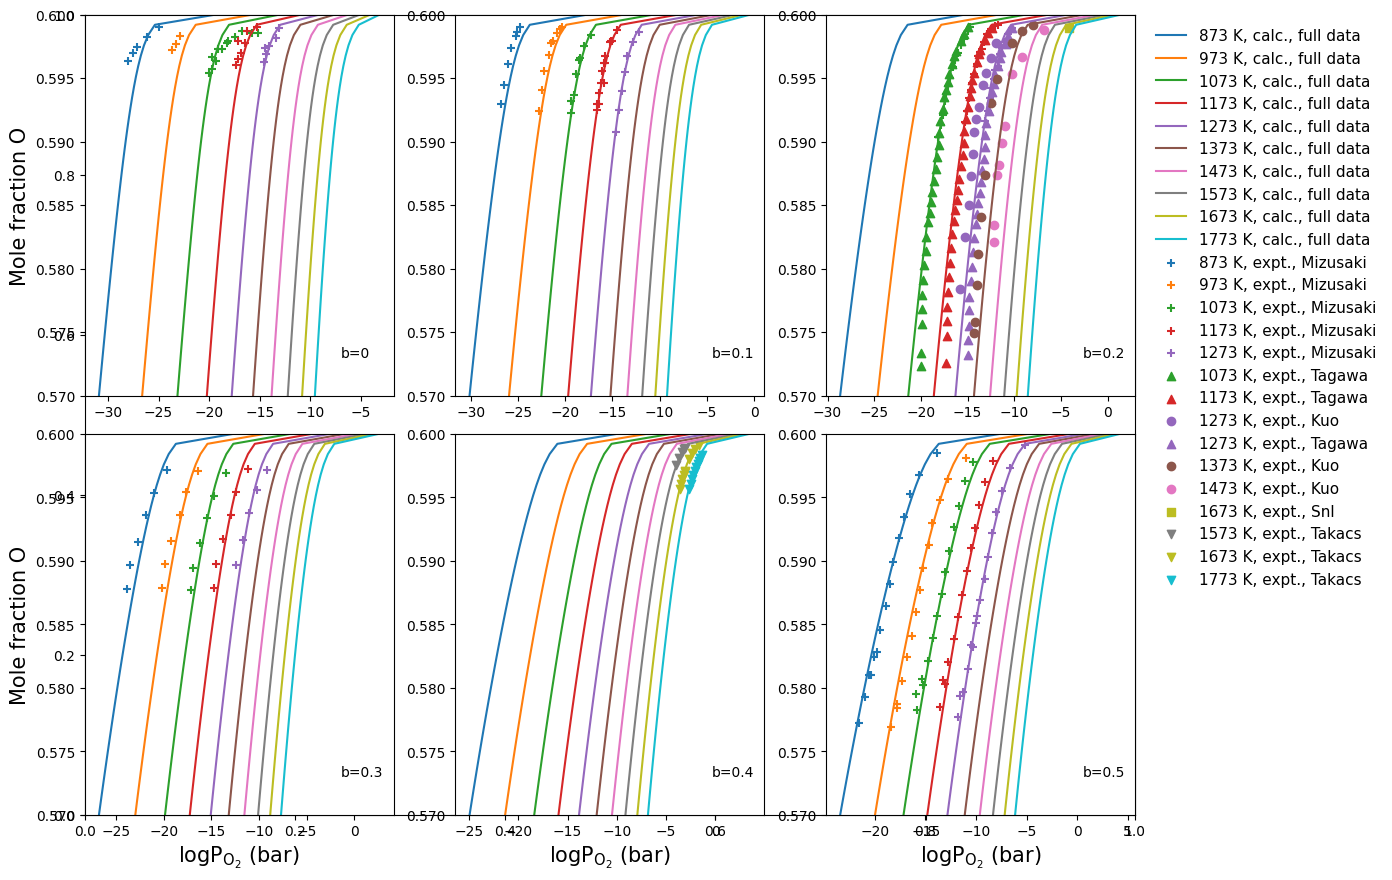

In [10]:
S=-diff(G,T)
H=G+T*S
H=simplify(H.expand())

# O chemical potential
mu_O=-diff(G,y[-1])/3
mu_O=simplify(mu_O.expand())

# calculate thermodynamic properties
def thermocalc(temperature,n):
    print('temperature: '+str(temperature)+' K, n='+str(n))
    def g(x):
        T=temperature
        #"""lsm
        y0,y1,y2,y3=x
        ntot=5-y1-y2-3*y3
        g=eval(str(G))/ntot
        return g
    def muo(x):
        T=temperature
        y0,y1,y2,y3=x
        mu=eval(str(mu_O))
        return mu
    nl=len(y)
    def ef(n,d,x0=[1e-2 for i in range(nl)]):
        bnds = tuple([(1e-15, 1-1e-15) for i in range(nl)])
        cons=({'type': 'eq', 'fun': lambda x:  x[0]/(1-x[1])-n },
            {'type': 'eq', 'fun': lambda x:  x[1]-x[2] },
            {'type': 'eq', 'fun': lambda x:  3*(1-x[3])/(1-x[2])-3+d })
        res=minimize(g, x0=x0, bounds=bnds, method='SLSQP',constraints=cons,tol=1e-15)
        gg=g(res.x)
        mu=muo(res.x)
        pO2=(mu-G_O_ip(temperature))/(1/2*r*temperature) # ln(p/p0)
        pO2=pO2/(np.log(10))
        return res.x,float(gg),float(mu),float(pO2)
    dmax=0.35 
    dmin=0
    dstep=0.01
    d=[dmin+1e-5]+[dmin+i*dstep for i in range(1,int((dmax-dmin)/dstep)+1)]
    x=[[] for i in d]
    gg=[0 for i in d]
    mu=[0 for i in d]
    pO2=[0 for i in d]
    for i in range(len(d)):
        if i==0:
            x[i],gg[i],mu[i],pO2[i]=ef(n,d[i],x0=[1e-2 for i in range(nl)])
        else:
            x[i],gg[i],mu[i],pO2[i]=ef(n,d[i],x0=x[i-1])
    return d,x,gg,mu,pO2


import math
from monty.serialization import loadfn,dumpfn
# res_dir='results_wexpt/'
fig = plt.figure(figsize=(math.ceil(len(y0_values)/2)*5,2*5))
temperatures=[873+100*i for i in range(10)]
results=[[] for m in range(len(y0_values))]
ho=[[] for m in range(len(y0_values))] #reduction enthalpy 
so=[[] for m in range(len(y0_values))] #eduction entropy
plt.cla()

handles, labels = [], []

# Create folder for results
create_directory(res_dir)

# calculate and plot x(O)-p(O2)
for m in range(len(y0_values)):
    res_file = res_dir+'results_'+str(y0_values[m])+'.json'
    if os.path.exists(res_file) and not overwrite_results: # read existing results
        print("Reading thermodynamics from file instead of re-computing")
        res = loadfn(res_file)
        d=res['d'];x=res['x'];gg=res['gg'];mu=res['mu'];pO2=res['pO2']
    else: 
        print("Computing thermodynamics and writing to file")
        results[m]=[thermocalc(i,n=y0_values[m]+1e-5) for i in temperatures]
        d=[i[0] for i in results[m]]
        x=[i[1] for i in results[m]]
        gg=[i[2] for i in results[m]]
        mu=[i[3] for i in results[m]]
        pO2=[i[4] for i in results[m]]
        res={'d':d,'x':x,'gg':gg,'mu':mu,'pO2':pO2}
        dumpfn(res,res_file)

    ax = fig.add_subplot(2, math.ceil(len(y0_values)/2), m+1)
    for i in range(len(temperatures)):
        ntot=[5-x[i][j][1]-x[i][j][2]-3*x[i][j][3] for j in range(len(x[i]))]
        x_O=[(3-3*x[i][j][3])/ntot[j] for j in range(len(x[i]))]
        ax.plot(pO2[i],x_O,label=str(temperatures[i])+' K, calc., full data',color=color_table[i])
    import glob
    fexpt0=glob.glob('expt_*')
    names0=[i.split('_')[1].capitalize() for i in fexpt0]
    names0=[''.join(i for i in j if not i.isdigit()) for j in names0]
    names = []
    null=[names.append(i) for i in names0 if not i in names]
    fexpt=[]
    for j in range(len(fexpt0)):
        with open(fexpt0[j],'r') as files:
            if float(files.readlines()[0].strip('#'))==y0_values[m]:
                fexpt.append(fexpt0[j])
    expt=[np.loadtxt(i) for i in fexpt]
    shape=['o','s','v','^','+','*']
    for i in range(len(temperatures)):
        for j in range(len(expt)):
            try:
                expt_current=expt[j][expt[j][:,2]==temperatures[i]]
                expt_current=expt_current[expt_current[:,1]<emax]
                if len(expt_current)!=0:
                    name=''.join(i for i in fexpt[j] if not i.isdigit()).replace('_','., ').replace('expt., ','').capitalize()
                    label=str(temperatures[i])+' K, expt., '+name
                    plt.scatter(np.log10(expt_current[:,0]),expt_current[:,1]/(expt_current[:,1]+2),marker=shape[names.index(name)],label=label,color=color_table[i])
            except:
                pass
    plt.text(0.83,0.1,'b='+str(y0_values[m]),transform=ax.transAxes)
    plt.ylim([0.57,0.6])
    if m/(math.ceil(len(y0_values)/2))>=1:
        plt.xlabel("$\mathregular{logP_{O_2}}$ (bar)",fontsize=15)
    if m%(math.ceil(len(y0_values)/2))==0:
        plt.ylabel('Mole fraction O',fontsize=15)
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

handles_labels = dict(zip(labels, handles))
fig.legend(handles_labels.values(), handles_labels.keys(), loc="upper right",bbox_to_anchor=(0.97, 0.9),prop={'size': 11},frameon=False)
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.1)
plt.savefig("fit_agreement.pdf")




<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:72: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:72: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81622/3377642027.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathregular{δ}$",fontsize=15)
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81622/3377642027.py:62: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathregular{Δh_O}$ (kJ/mol)",fontsize=15)
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81622/3377642027.py:71: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathregular{δ}$",fontsize=15)
/var/folders/ng/25b6m7n90c78bk8x_235kxj4000gdz/T/ipykernel_81

y0_values: [0, 0.1, 0.2, 0.3, 0.4, 0.5]


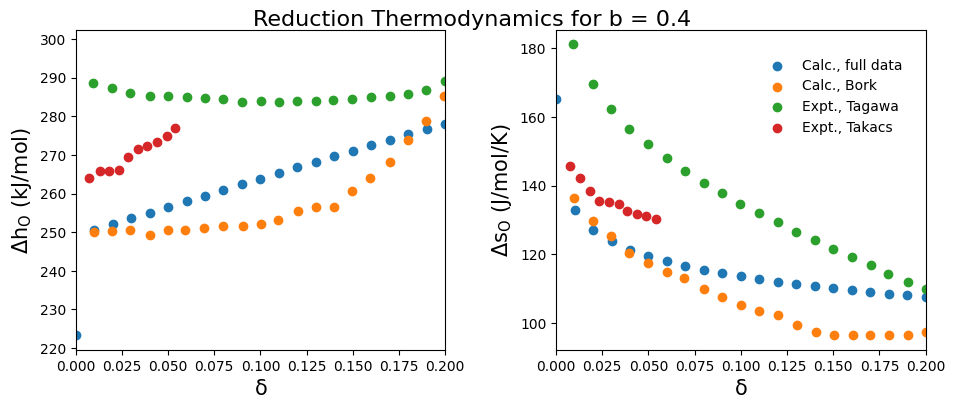

In [11]:
# calculate reduction enthalpy and entropy
# for m in range(len(y0_values)):
#     res_file = res_dir+'results_'+str(y0_values[m])+'.json'
#     if not os.path.exists(res_file):
#         results[m]=[thermocalc(i,n=y0_values[m]+1e-5) for i in temperatures]
#         d=[i[0] for i in results[m]]
#         x=[i[1] for i in results[m]]
#         gg=[i[2] for i in results[m]]
#         mu=[i[3] for i in results[m]]
#         pO2=[i[4] for i in results[m]]
#         res={'d':d,'x':x,'gg':gg,'mu':mu,'pO2':pO2}
#         dumpfn(res,res_file)
#     else:
#         res = loadfn(res_file)
#         d=res['d'];x=res['x'];gg=res['gg'];mu=res['mu'];pO2=res['pO2']
#     for j in range(0,len(d[0])):
#         # Van 't Hoff 
#         lnp=[0.5*pO2[i][j]*np.log(10) for i in range(len(temperatures))]
#         hoy,soy = np.polyfit(1/np.array(temperatures),lnp, 1)
#         hoy=-hoy*R/1000 # kJ/mol
#         soy=soy*R # J/K/mol
#         ho[m].append(hoy)
#         so[m].append(soy)

# assume that results has either been computed or loaded before
for m in range(len(y0_values)):
    d=[i[0] for i in results[m]]
    x=[i[1] for i in results[m]]
    gg=[i[2] for i in results[m]]
    mu=[i[3] for i in results[m]]
    pO2=[i[4] for i in results[m]]
    for j in range(0,len(d[0])):
        # Van 't Hoff 
        lnp=[0.5*pO2[i][j]*np.log(10) for i in range(len(temperatures))]
        hoy,soy = np.polyfit(1/np.array(temperatures),lnp, 1)
        hoy=-hoy*R/1000 # kJ/mol
        soy=soy*R # J/K/mol
        ho[m].append(hoy)
        so[m].append(soy)

print("y0_values:",y0_values)

# Write reduction enthalpy and entropy to file for b=0.2
b_idxs = [2,3,4]
for b_idx in b_idxs:
    b_val = y0_values[b_idx]
    reduction_thermo_data = np.column_stack((d[b_idx], ho[b_idx], so[b_idx]))
    # Write to a text file
    np.savetxt(f"reduction_thermo_data_b={b_val}.txt", reduction_thermo_data, header='d, ho, so', delimiter=',', fmt='%.6g')

b_idx = 4
b_val = y0_values[b_idx]
# plot reduction enthalpy and entropy for b=0.4
fig = plt.figure(figsize=(2*5,4))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(d[b_idx],ho[b_idx],label='Calc., full data')
ho2,ho3,ho4=np.loadtxt('ho_Calc_Rupp'),np.loadtxt('ho_Expt_Tagawa'),np.loadtxt('ho_Expt_Takacs')
ax.scatter(ho2[:,0],ho2[:,1],label='Calc., Bork')
ax.scatter(ho3[:,0],ho3[:,1],label='Expt., Tagawa')
ax.scatter(ho4[:,0],ho4[:,1],label='Expt., Takacs')
plt.xlabel("$\mathregular{δ}$",fontsize=15)
plt.ylabel("$\mathregular{Δh_O}$ (kJ/mol)",fontsize=15)
plt.xlim([0,0.2])

ax = fig.add_subplot(1, 2, 2)
ax.scatter(d[b_idx],so[b_idx],label='Calc., full data')
so2,so3,so4=np.loadtxt('so_Calc_Rupp'),np.loadtxt('so_Expt_Tagawa'),np.loadtxt('so_Expt_Takacs')
ax.scatter(so2[:,0],so2[:,1],label='Calc., Bork')
ax.scatter(so3[:,0],so3[:,1],label='Expt., Tagawa')
ax.scatter(so4[:,0],so4[:,1],label='Expt., Takacs')
plt.xlabel("$\mathregular{δ}$",fontsize=15)
plt.ylabel("$\mathregular{Δs_O}$ (J/mol/K)",fontsize=15)
plt.xlim([0,0.2])

plt.legend(loc="upper right",bbox_to_anchor=(0.97, 0.95),frameon=False)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.13, top=0.93, wspace=0.3, hspace=0.1)
fig.suptitle(f"Reduction Thermodynamics for b = {b_val} ", fontsize=16)
plt.savefig(f"reduction_h_s_b={b_val}.pdf")
